In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import time

/Users/annacjacobson/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
file = './TestData/ny_0287.rttm'

### RTTM to Dataframe

In [3]:
# Step 1: Load the .rttm into a dataframe
def DfFromRttm(rttm):
    """ Given an RTTM file, parses it into a Pandas DataFrame.
    """
    df = pd.read_csv(rttm,
                     sep=' ',
                     names=['task','inputFile','one','start','duration',
                     'NA_1','NA_2','class','NA_3', 'NA_4'])    
    
    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) \
        .drop(
        columns=[
            'task',
            'inputFile',
            'one',
            'NA_1',
            'NA_2',
            'NA_3',
            'NA_4'])
    
    return vizframe

## Audiozation Data

In [4]:
def RttmToUtteranceIndexedSpeakerActivity(df, outfile=None):
    """ Given an RTTM input file, generate a dataframe structured
        to support a visualization of type 'Speaker Activity' and optionally
        export to a csv located at {outfile}

        df = Pandas DataFrame containing a standard .rttm file
        outfile = destination for exported CSV (path, filename, extension)
    """

    # Check whether an outfile has been defined
    if outfile is not None:
        export = True
    else: 
        export = False

    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) 

    # Rename columns for our viz's purposes
    vizframe = vizframe.rename(columns={
        'start': 'START',
        'duration': 'DUR',
        'class': 'LABEL'
    })

    # Remap the model classes for this viz's purposes
    vizframe['LABEL'] = vizframe['LABEL'].map({
        'KCHI': 'CHILD',
        'CHI': 'CHILD',
        'FEM': 'ADULT',
        'MAL': 'ADULT'
    })

    # Filter the dataframe to just the 'clean' (non-'SPEECH') classes
    vizframe = vizframe[vizframe['LABEL'].isin(['CHILD', 'ADULT'])]
    vizframe['LABEL_NUM'] = vizframe['LABEL'] \
        .apply(lambda x: 1 if x == 'CHILD'
               else (-1 if x == 'ADULT' else NaN))
    vizframe['DUR_TRANS'] = vizframe['LABEL_NUM'] * vizframe['DUR']
    vizframe['COUNT'] = 1

    if export:
        vizframe.to_csv(outfile)

    return vizframe

In [5]:
RttmToUtteranceIndexedSpeakerActivity(DfFromRttm(file), outfile=None)

,START,DUR,LABEL,LABEL_NUM,DUR_TRANS,COUNT
1,6.105,0.775,ADULT,-1,-0.775,1
2,6.333,0.177,CHILD,1,0.177,1
3,6.755,0.236,CHILD,1,0.236,1
5,9.624,0.648,ADULT,-1,-0.648,1
6,12.488,1.963,ADULT,-1,-1.963,1
10,18.370,1.622,ADULT,-1,-1.622,1
12,22.850,0.230,ADULT,-1,-0.230,1
13,25.392,1.107,ADULT,-1,-1.107,1
16,27.452,4.862,ADULT,-1,-4.862,1
17,29.077,0.429,CHILD,1,0.429,1


## Time-Indexed Dataframe

In [6]:
## Identify the latest timestamp we need.
def GetLatestTimestampNeeded(input_df, verbose=True):
    """ Given an RTTM-derived dataframe,
        extract the last timestamp we'll need
        as a scalar. It will be the maximum value of
        the `start` + `duration` columns.
    """
    input_df['end_time'] = input_df['start'] + input_df['duration']
    end_row = input_df['end_time'].idxmax()
    latest_timestamp = input_df.at[end_row,'start'] + input_df.at[end_row,'duration']
    if verbose:
        print(f'''
        >> This DF has data that runs until {latest_timestamp}.
        >> That value was found at row {end_row} and is the sum of
           {input_df.at[end_row, 'start']} and {input_df.at[end_row, 'duration']}
        ''')
    return latest_timestamp

In [7]:
## Create millisecond index.
def MakeMillisecondIntegerIndexedDf(
        start,
        duration,
        colname='value',
        colvalue='',
        decimals=4,
        verbose=False):
    """ Create an integer-indexed dataframe covering a 
            {duration} from
            {start} having a single column with the name
            {colname} that contains a default value of
            {colvalue} for that named column.
        By default it runs quietly rather than {verbose}.
    """

    if verbose:
        print(f' >>> From [{start}] for [{duration}] seconds' \
              f' until [{start+duration}] the col [{colname}]' \
              f' will contain the value [{colvalue}]')
    
    # Create a range between the start and stop
    rng = pd.RangeIndex(start = int(round(start, decimals)*1000),
                        stop  = int(round(start+duration, decimals)*1000),
                        step  = 1)
    
    # Turn that series into a DataFrame and rename the index for clarity
    df = pd.Series(colvalue, index=rng).to_frame(name=colname)
    df.index.name=f'millisecond_ints'
    if verbose:
        print(df.head(3), df.tail(3))
    return df

In [8]:
## Subset by label.
def SubsetDfByLabel(df, column_list, key_col, value):
    """ Given a dataframe {df}, return the subset
        of the dataframe defined by {column_list}
        containing {value} in the {key_col} column
    """
    return df[df[key_col] == value][[x for x in column_list]]

In [9]:
# This is to make our lives easier later
ny_7759 = DfFromRttm(file)
ny_7759_bak = copy.deepcopy(ny_7759)

In [10]:
# This is to make our lives easier later
ny_0287 = DfFromRttm(file)
ny_0287_bak = copy.deepcopy(ny_0287)

In [11]:
def BuildOneHotEncodedDf(
    input_df,
    label_list=[],
    verbose=True
    ):
    """ Given an RTTM-generated DataFrame, generate a DF containing
        all of the labels of interest in one-hot encoded format
        against an integer-indexed DF representing milliseconds from
        the beginning of the recording
    """
    
    max_seconds_needed = GetLatestTimestampNeeded(input_df)
    if verbose:
        print(f'max_seconds_needed is equal to {max_seconds_needed}')

    outer_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = max_seconds_needed,
                colname    = 'base_col',
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = True)

    if verbose:
        print(f'The outer_df frame will contain {outer_df.shape[0]} records.')
    
    # Loop through labels, subsetting the original DF so
    # we can merge it back into the main outer DF
    for label in label_list:
        print(f'>>> Processing label: {label}\n')

        if label not in input_df['class'].unique():
            print(f'Label {label} not found in this dataset')
            label_base_df = pd.DataFrame(columns=[label])
            continue
        
        # Gotta avoid errors from accidentally manipulating original DFs
        temp_df = copy.deepcopy(input_df)

        # Replace the deep-copied DF with a subset of itself
        # that contains only records for the label of interest
        temp_df = SubsetDfByLabel(
            input_df,
            column_list = ['start', 'duration', 'class'],
            key_col     = 'class',
            value       = label
        )

        if verbose:
            print(f'The temp_df subset for label {label}' \
                  f' contains {temp_df.shape[0]} rows')
            print(temp_df.head(5),
                  temp_df.tail(5))
        
        # The subsetted DF retains the original index unless you reset it
        temp_df.reset_index(drop=True,
                            inplace=True)
        
        if verbose:
            print(f'The temp_df frame is as follows:\n{temp_df}')

        # Creating the base DF for this label - ranges from 0 to the earliest record
        label_base_df = MakeMillisecondIntegerIndexedDf(
                start      = 0,
                duration   = temp_df['start'].min(),
                colname    = label,
                colvalue   = np.nan,
                decimals   = 4,
                verbose    = verbose)
        
        if verbose:
            # The head() will always be the same, so we need to look at the tail() to verify
            print('\n>>> The last few rows of the label_base_df for label' \
                  f' {label} are:\n{label_base_df.tail()}' \
                  f'\n>>> Base DF size for label {label}: {len(temp_df)}\n')

        for i in temp_df.index:
            if verbose:
                print('*' * 10 + f'{label}: i = {i}' + '*' * 10)
            s, d, cn = temp_df.loc[i, ['start', 'duration', 'class']]
            label_base_df = label_base_df.append(
                MakeMillisecondIntegerIndexedDf(
                    start    = s,
                    duration = d,
                    colname  = cn,
                    colvalue = 1,
                    decimals = 4,
                    verbose  = verbose
                ))
            
            if verbose:
                print(f'\n>>> Base DF size after {i}' \
                      ' rounds: {len(label_base_df)}')
                print(f'\n>>> The head:\n{label_base_df.head(10)}'\
                      f'\n>>> The tail:\n{label_base_df.tail(10)}')
                print('\n>>> A few of its contents:'\
                      f'\n{label_base_df[~label_base_df[label].isna()].head(5)}')

        # Creating a placeholder for the update call
        outer_df[label] = np.nan
        
        # When attempting the update method:
        print(f'Attempting update with DF from label {label}')
        outer_df.update(
            other     = label_base_df,
            overwrite = True)
        
        if verbose:
            try:
                print(outer_df[~outer_df[label].isna()].head())
            except:
                print(outer_df)
            
    return outer_df

In [12]:
tester = DfFromRttm(file)
labels = ['MAL', 'CHI', 'KCHI', 'FEM', 'SPEECH']
tester[['start', 'duration']].loc[2]

start       6.333
duration    0.177
Name: 2, dtype: float64

In [13]:
result = BuildOneHotEncodedDf(tester, label_list=labels, verbose=True)


        >> This DF has data that runs until 151.80100000000002.
        >> That value was found at row 43 and is the sum of
           110.305 and 41.496
        
max_seconds_needed is equal to 151.80100000000002
 >>> From [0] for [151.80100000000002] seconds until [151.80100000000002] the col [base_col] will contain the value [nan]
                  base_col
millisecond_ints          
0                      NaN
1                      NaN
2                      NaN                   base_col
millisecond_ints          
151798                 NaN
151799                 NaN
151800                 NaN
The outer_df frame will contain 151801 records.
>>> Processing label: MAL

The temp_df subset for label MAL contains 15 rows
     start  duration class
1    6.105     0.775   MAL
5    9.624     0.648   MAL
6   12.488     1.963   MAL
10  18.370     1.622   MAL
12  22.850     0.230   MAL       start  duration class
35   81.106     1.883   MAL
37   91.704     0.275   MAL
53  131.232     0.127  


>>> A few of its contents:
                  MAL
millisecond_ints     
6105              1.0
6106              1.0
6107              1.0
6108              1.0
6109              1.0
**********MAL: i = 10**********
 >>> From [81.10600000000001] for [1.883] seconds until [82.989] the col [MAL] will contain the value [1]
                  MAL
millisecond_ints     
81106               1
81107               1
81108               1                   MAL
millisecond_ints     
82986               1
82987               1
82988               1

>>> Base DF size after 10 rounds: {len(label_base_df)}

>>> The head:
                  MAL
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  MAL
millisecond_ints     
82979             1.0
82980             1.0
82981             1.0
8

>>> Processing label: KCHI

The temp_df subset for label KCHI contains 14 rows
     start  duration class
2    6.333     0.177  KCHI
3    6.755     0.236  KCHI
17  29.077     0.429  KCHI
18  29.992     0.500  KCHI
19  31.772     0.471  KCHI       start  duration class
34   80.958     0.179  KCHI
39  102.178     0.704  KCHI
45  120.493     0.500  KCHI
48  121.510     1.144  KCHI
51  123.572     0.415  KCHI
The temp_df frame is as follows:
      start  duration class
0     6.333     0.177  KCHI
1     6.755     0.236  KCHI
2    29.077     0.429  KCHI
3    29.992     0.500  KCHI
4    31.772     0.471  KCHI
5    38.620     0.326  KCHI
6    51.288     1.566  KCHI
7    61.479     1.142  KCHI
8    78.666     0.346  KCHI
9    80.958     0.179  KCHI
10  102.178     0.704  KCHI
11  120.493     0.500  KCHI
12  121.510     1.144  KCHI
13  123.572     0.415  KCHI
 >>> From [0] for [6.332999999999999] seconds until [6.332999999999999] the col [KCHI] will contain the value [nan]
                  KCHI

                  KCHI
millisecond_ints      
80958                1
80959                1
80960                1                   KCHI
millisecond_ints      
81134                1
81135                1
81136                1

>>> Base DF size after 9 rounds: {len(label_base_df)}

>>> The head:
                  KCHI
millisecond_ints      
0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
>>> The tail:
                  KCHI
millisecond_ints      
81127              1.0
81128              1.0
81129              1.0
81130              1.0
81131              1.0
81132              1.0
81133              1.0
81134              1.0
81135              1.0
81136              1.0

>>> A few of its contents:
                  KCHI
millisecond_ints      
6333               1.0
6334               1.0
6335          

51590               1

>>> Base DF size after 2 rounds: {len(label_base_df)}

>>> The head:
                  FEM
millisecond_ints     
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
5                 NaN
6                 NaN
7                 NaN
8                 NaN
9                 NaN
>>> The tail:
                  FEM
millisecond_ints     
51581             1.0
51582             1.0
51583             1.0
51584             1.0
51585             1.0
51586             1.0
51587             1.0
51588             1.0
51589             1.0
51590             1.0

>>> A few of its contents:
                  FEM
millisecond_ints     
27452             1.0
27453             1.0
27454             1.0
27455             1.0
27456             1.0
**********FEM: i = 3**********
 >>> From [52.242] for [4.907] seconds until [57.149] the col [FEM] will contain the value [1]
                  FEM
millisecond_ints     
52242         

                  base_col  MAL  CHI  KCHI  FEM
millisecond_ints                               
27452                  NaN  NaN  NaN   NaN  1.0
27453                  NaN  NaN  NaN   NaN  1.0
27454                  NaN  NaN  NaN   NaN  1.0
27455                  NaN  NaN  NaN   NaN  1.0
27456                  NaN  NaN  NaN   NaN  1.0
>>> Processing label: SPEECH

The temp_df subset for label SPEECH contains 12 rows
    start  duration   class
0   5.986     1.507  SPEECH
4   8.571     2.474  SPEECH
7  14.642     0.245  SPEECH
8  14.992     0.748  SPEECH
9  15.992     1.019  SPEECH       start  duration   class
15   27.427    11.742  SPEECH
25   39.292    17.861  SPEECH
30   61.415    47.120  SPEECH
42  109.202     0.967  SPEECH
43  110.305    41.496  SPEECH
The temp_df frame is as follows:
      start  duration   class
0     5.986     1.507  SPEECH
1     8.571     2.474  SPEECH
2    14.642     0.245  SPEECH
3    14.992     0.748  SPEECH
4    15.992     1.019  SPEECH
5    21.630     2.36

108534               1.0

>>> A few of its contents:
                  SPEECH
millisecond_ints        
5986                 1.0
5987                 1.0
5988                 1.0
5989                 1.0
5990                 1.0
**********SPEECH: i = 10**********
 >>> From [109.20200000000001] for [0.9670000000000001] seconds until [110.16900000000001] the col [SPEECH] will contain the value [1]
                  SPEECH
millisecond_ints        
109202                 1
109203                 1
109204                 1                   SPEECH
millisecond_ints        
110166                 1
110167                 1
110168                 1

>>> Base DF size after 10 rounds: {len(label_base_df)}

>>> The head:
                  SPEECH
millisecond_ints        
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9     

In [14]:
result.head(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
result.tail(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
151781,NaN,NaN,NaN,NaN,1.0,1.0
151782,NaN,NaN,NaN,NaN,1.0,1.0
151783,NaN,NaN,NaN,NaN,1.0,1.0
151784,NaN,NaN,NaN,NaN,1.0,1.0
151785,NaN,NaN,NaN,NaN,1.0,1.0
151786,NaN,NaN,NaN,NaN,1.0,1.0
151787,NaN,NaN,NaN,NaN,1.0,1.0
151788,NaN,NaN,NaN,NaN,1.0,1.0
151789,NaN,NaN,NaN,NaN,1.0,1.0


In [16]:
result.loc[60:70,]

,base_col,MAL,CHI,KCHI,FEM,SPEECH
millisecond_ints,,,,,,
60,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN
62,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,NaN,NaN,NaN,NaN,NaN
68,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
result.describe()

,base_col,MAL,CHI,KCHI,FEM,SPEECH
count,0.0,14887.0,4360.0,8135.0,113980.0,128916.0
mean,NaN,1.0,1.0,1.0,1.0,1.0
std,NaN,0.0,0.0,0.0,0.0,0.0
min,NaN,1.0,1.0,1.0,1.0,1.0
25%,NaN,1.0,1.0,1.0,1.0,1.0
50%,NaN,1.0,1.0,1.0,1.0,1.0
75%,NaN,1.0,1.0,1.0,1.0,1.0
max,NaN,1.0,1.0,1.0,1.0,1.0


In [18]:
result.shape

(151801, 6)

### Data Cleanup

In [19]:
# Drop base_col and SPEECH columns
result = result.drop(['base_col', 'SPEECH'], axis=1).fillna(0)

In [20]:
# Combine MAL/FEM and KCHI/CHI
result['ADULT'] = result.apply(lambda x: 0 if (x['MAL']==0 and x['FEM']==0) else 1, axis=1)
result['CHILD'] = result.apply(lambda x: 0 if (x['KCHI']==0 and x['CHI']==0) else 1, axis=1)

In [21]:
# Drop MAL/FEM and KCHI/CHI columns
result = result.drop(['MAL', 'CHI', 'KCHI', 'FEM'], axis=1)

In [22]:
# Combine ADULT and CHILD columns
result['SPEECH'] = result.apply(lambda x: 0 if (x['ADULT']==0 and x['CHILD']==0) else 1, axis=1)

In [23]:
# Smooth data by eliminating pauses less than 1 sec between consecutive statements.

adult_window_back = result['ADULT'].rolling(1000).sum()
adult_window_for = result['ADULT'].iloc[::-1].rolling(1000).sum()

child_window_back = result['CHILD'].rolling(1000).sum()
child_window_for = result['CHILD'].iloc[::-1].rolling(1000).sum()

result['SMOOTH_A'] = np.where((adult_window_back >= 1) & (adult_window_for >= 1), 1, 0)
result['SMOOTH_C'] = np.where((child_window_back >= 1) & (child_window_for >= 1), 1, 0)

In [24]:
# Combine SMOOTH_A and SMOOTH_C columns
result['SMOOTH_S'] = result.apply(lambda x: 0 if (x['SMOOTH_A']==0 and x['SMOOTH_C']==0) else 1, axis=1)

In [25]:
result.loc[6505:6555,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S
millisecond_ints,,,,,,
6505,1,1,1,1,1,1
6506,1,1,1,1,1,1
6507,1,1,1,1,1,1
6508,1,1,1,1,1,1
6509,1,1,1,1,1,1
6510,1,0,1,1,1,1
6511,1,0,1,1,1,1
6512,1,0,1,1,1,1
6513,1,0,1,1,1,1


### Calculated Variables

In [26]:
# Identify overlaps and pauses.
result['OVERLAP'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 2, 1, 0)
result['PAUSE'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 0, 1, 0)

# Identify overlaps and pauses based on smoothed data.
result['SMOOTH_OVERLAP'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 2, 1, 0)
result['SMOOTH_PAUSE'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 0, 1, 0)

In [27]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['UTT_A'] = result.ADULT.diff()
result['UTT_C'] = result.CHILD.diff()
result['UTT_S'] = result.SPEECH.diff()

result['SMOOTH_UTT_A'] = result.SMOOTH_A.diff()
result['SMOOTH_UTT_C'] = result.SMOOTH_C.diff()
result['SMOOTH_UTT_S'] = result.SMOOTH_S.diff()

In [28]:
result.loc[6505:6555,]

,ADULT,CHILD,SPEECH,SMOOTH_A,SMOOTH_C,SMOOTH_S,OVERLAP,PAUSE,SMOOTH_OVERLAP,SMOOTH_PAUSE,UTT_A,UTT_C,UTT_S,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_UTT_S
millisecond_ints,,,,,,,,,,,,,,,,
6505,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
6506,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
6507,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
6508,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
6509,1,1,1,1,1,1,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
6510,1,0,1,1,1,1,0,0,1,0,0.0,-1.0,0.0,0.0,0.0,0.0
6511,1,0,1,1,1,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
6512,1,0,1,1,1,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0
6513,1,0,1,1,1,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0


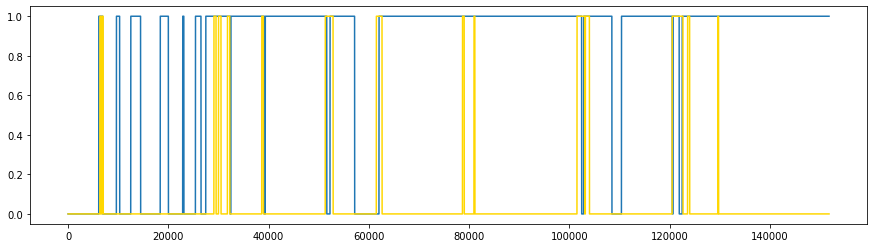

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(result.index, result['ADULT'])
plt.plot(result.index, result['CHILD'], color='gold')
plt.show()

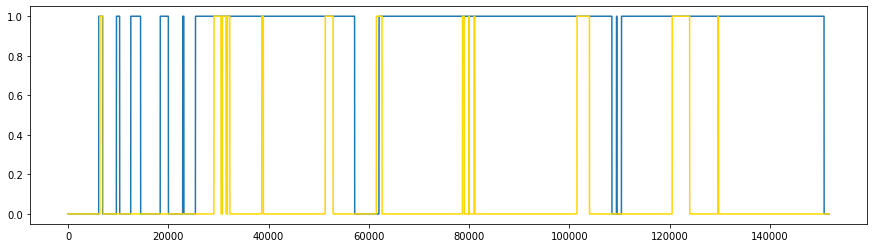

In [30]:
plt.figure(figsize=(15, 4))
plt.plot(result.index, result['SMOOTH_A'])
plt.plot(result.index, result['SMOOTH_C'], color='gold')
plt.show()

In [31]:
result.to_csv('./TestData/eNY-0287.csv')

## TeacherPrint Data

In [32]:
def convert(n): 
    return time.strftime("%M min %S sec", time.gmtime(n))

### Summary

In [33]:
# Calculate the total time (sec).
tp_time = round(len(result.index)*.001,1)
print("TOTAL LESSON TIME: " + convert(tp_time)) 

TOTAL LESSON TIME: 02 min 31 sec


### Talk Time
#### Raw

In [34]:
# Calculate total talktime (sec).
tp_tt = round(((result['ADULT'].sum() + result['CHILD'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt)) 

# Calculate teacher talktime (sec and %).
tp_att = round(result['ADULT'].sum()*.001, 1)
tp_att_pc = int(round((tp_att/tp_tt)*100, 0))
print(tp_att, tp_att_pc)

# Calculate student talktime (sec and %).
tp_ctt = round(result['CHILD'].sum()*.001, 1)
tp_ctt_pc = int(round((tp_ctt/tp_tt)*100, 0))
print(tp_ctt, tp_ctt_pc)

print('During your lesson you spoke ' 
      + str(tp_att_pc) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric = int(round(tp_att/tp_ctt, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 02 min 12 sec
121.8 92
10.4 8
During your lesson you spoke 92% of the time and the Students spoke 8% of the time.
For every second of Student talk time, there were about 12 seconds of Teacher talk time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [46]:
# Calculate total smoothed talktime (sec).
tp_tt_s = round(((result['SMOOTH_A'].sum() + result['SMOOTH_C'].sum())*.001), 1)
print("TOTAL TALK TIME: " + convert(tp_tt_s)) 

# Calculate teacher talktime (sec and %).
tp_att_s = round(result['SMOOTH_A'].sum()*.001, 1)
tp_att_pc_s = int(round((tp_att_s/tp_tt_s)*100, 0))
print(tp_att_s, tp_att_pc_s)

# Calculate student talktime (sec and %).
tp_ctt_s = round(result['SMOOTH_C'].sum()*.001, 1)
tp_ctt_pc_s = int(round((tp_ctt_s/tp_tt_s)*100, 0))
print(tp_ctt_s, tp_ctt_pc_s)

print('During your lesson you spoke ' 
      + str(tp_att_pc_s) + '% of the time and the Students spoke ' 
      + str(tp_ctt_pc_s) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric_s = int(round(tp_att_s/tp_ctt_s, 0))

print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric_s) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 02 min 16 sec
124.0 91
13.0 9
During your lesson you spoke 91% of the time and the Students spoke 9% of the time.
For every second of Student talk time, there were about 10 seconds of Teacher talk time.


### Statements
#### Raw

In [50]:
#Calculate number of statements.
tp_utt_a = result['UTT_A'].value_counts()[1]
tp_utt_c = result['UTT_C'].value_counts()[1]
tp_utt = tp_utt_a + tp_utt_c
print(tp_utt, tp_utt_a, tp_utt_c)

# Calculate average statement length.
tp_uttlen_a = round((tp_att/tp_utt_a), 1)
print(tp_uttlen_a)
tp_uttlen_c = round((tp_ctt/tp_utt_c), 1)
print(tp_uttlen_c)

print('Your average statement was ' 
      + str(tp_uttlen_a) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c) + ' seconds long.')

# Calculate the Statement metric ("For every second...".
tp_utt_metric = int(round(tp_uttlen_a/tp_uttlen_c, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric) + ' seconds of Teacher statements.')

30 15 15
8.1
0.7
Your average statement was 8.1 seconds long, while the average Student statement was 0.7 seconds long.
For every second of Student statements, there were about 12 seconds of Teacher statements.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [51]:
#Calculate number of smoothed statements.
tp_utt_a_s = result['SMOOTH_UTT_A'].value_counts()[1]
tp_utt_c_s = result['SMOOTH_UTT_C'].value_counts()[1]
tp_utt_s = tp_utt_a_s + tp_utt_c_s
print(tp_utt_s, tp_utt_a_s, tp_utt_c_s)

# Calculate average smoothed statement length.
tp_uttlen_a_s = round((tp_att_s/tp_utt_a_s), 1)
print(tp_uttlen_a_s)
tp_uttlen_c_s = round((tp_ctt_s/tp_utt_c_s), 1)
print(tp_uttlen_c_s)

print('Your average statement was ' 
      + str(tp_uttlen_a_s) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_c_s) + ' seconds long.')


# Calculate the Statement metric ("For every second...".
tp_utt_metric_s = int(round(tp_uttlen_a_s/tp_uttlen_c_s, 0))

print('For every second of Student statements, there were about ' 
      + str(tp_utt_metric_s) + ' seconds of Teacher statements.')

22 9 13
13.8
1.0
Your average statement was 13.8 seconds long, while the average Student statement was 1.0 seconds long.
For every second of Student statements, there were about 14 seconds of Teacher statements.


### Switches
Questions for the team: a) do we care about switches? b) if so, how do we want to define them?

### Pauses

#### Raw

In [52]:
# Calculate pause time (sec).
tp_pt = round(result['PAUSE'].sum()*.001, 1)
tp_pt_avg = (round((tp_pt/tp_utt), 1))
print(tp_pt, tp_pt_avg)

#Calculate number of pauses.
tp_pause_a = result['UTT_A'].value_counts()[-1]
tp_pause_a_avg = (round((tp_pause_a/tp_utt_a), 1))
print(tp_pause_a, tp_pause_a_avg)

tp_pause_c = result['UTT_C'].value_counts()[-1]
tp_pause_c_avg = (round((tp_pause_c/tp_utt_c), 1))
print(tp_pause_c, tp_pause_c_avg)

tp_pause_c = result['UTT_S'].value_counts()[-1]
tp_pause_pc = int(round((tp_pause_c/tp_utt)*100, 0))
print(tp_pause_c, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc) 
      + '% of Statements had pauses between them.')

27.6 0.9
14 0.9
15 1.0
10 33
On average, the Students waited 0.9 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 33% of Statements had pauses between them.


#### Smoothed

In [53]:
# Calculate pause time (sec).
tp_pt_s = round(result['SMOOTH_PAUSE'].sum()*.001, 1)
tp_pt_avg_s = (round((tp_pt_s/tp_utt_s), 1))
print(tp_pt_s, tp_pt_avg_s)

#Calculate number of pauses.
tp_pause_a_s = result['SMOOTH_UTT_A'].value_counts()[-1]
tp_pause_a_avg_s = (round((tp_pause_a_s/tp_utt_a_s), 1))
print(tp_pause_a_s, tp_pause_a_avg_s)

tp_pause_c_s = result['SMOOTH_UTT_C'].value_counts()[-1]
tp_pause_c_avg_s = (round((tp_pause_c_s/tp_utt_c_s), 1))
print(tp_pause_c_s, tp_pause_c_avg_s)

tp_pause_s = result['SMOOTH_UTT_S'].value_counts()[-1]
tp_pause_pc_s = int(round((tp_pause_s/tp_utt_s)*100, 0))
print(tp_pause_s, tp_pause_pc)

print('On average, the Students waited ' +
      str(tp_pause_a_avg_s) + ' seconds after you stopped speaking to begin their turn. You typically waited ' +
      str(tp_pause_c_avg_s) + ' seconds to speak after the Students stopped.')

print('In this lesson, ' + str(tp_pause_pc_s) 
      + '% of Statements had pauses between them.')

27.2 1.2
9 1.0
13 1.0
9 33
On average, the Students waited 1.0 seconds after you stopped speaking to begin their turn. You typically waited 1.0 seconds to speak after the Students stopped.
In this lesson, 41% of Statements had pauses between them.


### Overlaps

#### Raw

In [54]:
# Calculate overlap time (sec).
tp_ot = round(result['OVERLAP'].sum()*.001, 1)
print(tp_ot)

tp_overlap_pc = 100 - tp_pause_pc

print('On average, when the Students began talking before you had finished, the overlap was about 0.4 seconds. When you spoke before they had finished, the overlap was 0.5 seconds. ')

print('In this lesson ' + str(tp_overlap_pc) 
      + '% of Statements had overlaps between them.')

8.0
On average, when the Students began talking before you had finished, the overlap was about 0.4 seconds. When you spoke before they had finished, the overlap was 0.5 seconds. 
In this lesson 67% of Statements had overlaps between them.


#### Smoothed

In [55]:
# Calculate smoothed overlap time (sec).
tp_ot_s = round(result['SMOOTH_OVERLAP'].sum()*.001, 1)
print(tp_ot_s)

tp_overlap_pc_s = 100 - tp_pause_pc_s

print('In this lesson ' + str(tp_overlap_pc_s) 
      + '% of Statements had overlaps between them.')

12.3
In this lesson 59% of Statements had overlaps between them.


### Speaker Wheel
#### Raw

In [56]:
# Calculate Speaker Wheel input values (percent).
sw_adult = int(round((tp_att-tp_ot)/tp_time*100))
sw_overlap = int(round(tp_ot/tp_time*100))
sw_child = int(round((tp_ctt-tp_ot)/tp_time*100))
sw_pause = int(round(tp_pt/tp_time*100))
sw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df

{'TEACHER': 75, 'OVERLAPS': 5, 'STUDENT': 2, 'PAUSES': 18}

#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [57]:
# Calculate Speaker Wheel input values (percent) based on smoothed data.
sw_adult_s = int(round((tp_att_s-tp_ot_s)/tp_time*100))
sw_overlap_s = int(round(tp_ot_s/tp_time*100))
sw_child_s = int(round((tp_ctt_s-tp_ot_s)/tp_time*100))
sw_pause_s = int(round(tp_pt_s/tp_time*100))
sw_df_s = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df_s

{'TEACHER': 75, 'OVERLAPS': 5, 'STUDENT': 2, 'PAUSES': 18}